In [1]:
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
# from decouple import config
import pprint
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from gemini_llm import GeminiLLM
import concurrent.futures
import json


/Users/pdwivedi/miniconda3/envs/llm_agents/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["GOOGLE_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents-planning'

## Define prompts for Generation, Reflection and Tool Execution

![Reflexion](images/Reflexion.png)

#### Generation Prompt

In [4]:
llm = GeminiLLM(model='gemini-1.5-flash-latest', temperature=0.3, response_mime_type='application/json')

In [5]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant researcher tasked with writing detailed 2-3 paragraph research on the topic presented by the user."
            "Along with the response, you will also give a list of 2-3 search suggestions that can be run to improve the research and ground it"
            "Give your output in JSON under 2 keys: 'answer' for your research response, 'search' for a list of search suggestions"
        ),
        (
            "user",
            "Write a report on the topic {task}"

        ),
    ]
)

generate_agent = generation_prompt | llm

In [6]:
result = generate_agent.invoke({"task": "Is the pace of climate change accelerating?"})
result = json.loads(result)
pprint.pprint(result)

{'answer': 'The pace of climate change is undeniably accelerating, evidenced '
           'by a multitude of indicators. Global average temperatures are '
           'rising at an unprecedented rate, with the past decade witnessing '
           'the warmest years on record. This warming trend is driving more '
           'frequent and intense heatwaves, droughts, and wildfires. '
           'Additionally, sea levels are rising at an accelerating pace, '
           'threatening coastal communities and ecosystems. The melting of '
           'glaciers and ice sheets is contributing to this rise, further '
           'exacerbating the problem. The frequency and intensity of extreme '
           'weather events, such as hurricanes and floods, are also '
           'increasing, causing significant damage and displacement. These '
           'trends are consistent with scientific projections and highlight '
           'the urgent need for immediate action to mitigate climate change.',
 'sear

In [7]:
initial_report = result['answer']
print(initial_report)

The pace of climate change is undeniably accelerating, evidenced by a multitude of indicators. Global average temperatures are rising at an unprecedented rate, with the past decade witnessing the warmest years on record. This warming trend is driving more frequent and intense heatwaves, droughts, and wildfires. Additionally, sea levels are rising at an accelerating pace, threatening coastal communities and ecosystems. The melting of glaciers and ice sheets is contributing to this rise, further exacerbating the problem. The frequency and intensity of extreme weather events, such as hurricanes and floods, are also increasing, causing significant damage and displacement. These trends are consistent with scientific projections and highlight the urgent need for immediate action to mitigate climate change.


#### Tool Usage node

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)

In [9]:
tool.invoke({"query": "Global temperature trends past decade"})

[{'url': 'https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature',
  'content': "According to NOAA's\xa02021 Annual Climate Report the combined\xa0land and ocean temperature has increased at an average rate of\xa00.14 degrees Fahrenheit ( 0.08 degrees\xa0Celsius)\xa0per decade since 1880; however, the average rate of increase since 1981 has been more than twice as fast: 0.32 °F (0.18 °C) per decade.\n According to the 2022 Global Climate Report from NOAA National Centers for Environmental Information, every month of 2022 ranked among the ten warmest for that month, despite the cooling influence from the La Niña climate pattern in the tropical Pacific. Because their goal is to track changes in temperature, measurements are converted from absolute\xa0temperature readings\xa0to temperature anomalies—the difference between the observed temperature and the long-term average temperature for each location and date. According to the 2017 U.S. Climate Scie

In [10]:
def execute_single_search(query):
    tool = TavilySearchResults(max_results=3) ## Keep only top 3 results
    result =tool.invoke({"query":query})
    return result

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]
    
def run_parallel_search(search_queries):
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(search_queries)) as executor:
        # Submit the API calls to the executor
        outputs = [executor.submit(execute_single_search, point) for point in search_queries]
        # Wait for the API calls to complete and get the results
        results = [future.result() for future in concurrent.futures.as_completed(outputs)]

    flatten = flatten_list(results)
    return flatten


In [11]:
search_queries = ['Global temperature trends past decade', 'Sea level rise acceleration rate', 'Frequency and intensity of extreme weather events']
search_results = run_parallel_search(search_queries)

In [12]:
print(search_results)

[{'url': 'https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature', 'content': "According to NOAA's\xa02021 Annual Climate Report the combined\xa0land and ocean temperature has increased at an average rate of\xa00.14 degrees Fahrenheit ( 0.08 degrees\xa0Celsius)\xa0per decade since 1880; however, the average rate of increase since 1981 has been more than twice as fast: 0.32 °F (0.18 °C) per decade.\n According to the 2022 Global Climate Report from NOAA National Centers for Environmental Information, every month of 2022 ranked among the ten warmest for that month, despite the cooling influence from the La Niña climate pattern in the tropical Pacific. Because their goal is to track changes in temperature, measurements are converted from absolute\xa0temperature readings\xa0to temperature anomalies—the difference between the observed temperature and the long-term average temperature for each location and date. According to the 2017 U.S. Climate Scienc

### Revision Request

In [13]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        #  this needs to be a tuple so do not forget the , at the end
        (
            "system",
            "You are an expert at revising research based on search results. Look at the current report, search queries and search results."
            "Use the search results to improve the report. Important: End your report by citing sources you used to write the report"
            "Also give me 2-3 search suggestions that will further improve the report. These should be different from the search queries that are already done"
            "Give your output in JSON under 2 keys: 'answer' for your research response with citation. Put citation URLs at the end., 'search' for a list of search suggestions"
        ),
        (
            "user",
            "The question from the user is {task}. The current report is {current_report} \n"
            "The search queries done so far are {search_queries}"
            "The search results are {search_results}"

        ),
    ]
)

reflect_agent = reflection_prompt | llm

In [14]:
result = reflect_agent.invoke({"task": "Is the pace of climate change accelerating?", "current_report": initial_report, "search_results": search_results, "search_queries": search_queries})
result = json.loads(result)
pprint.pprint(result)

{'answer': 'The pace of climate change is undeniably accelerating, as '
           'evidenced by numerous indicators. Global average temperatures are '
           'rising at an unprecedented rate, with the past decade witnessing '
           'the warmest years on record. This warming trend is driving more '
           'frequent and intense heatwaves, droughts, and wildfires. '
           'Additionally, sea levels are rising at an accelerating pace, '
           'threatening coastal communities and ecosystems. The melting of '
           'glaciers and ice sheets is contributing to this rise, further '
           'exacerbating the problem. The frequency and intensity of extreme '
           'weather events, such as hurricanes and floods, are also '
           'increasing, causing significant damage and displacement. These '
           'trends are consistent with scientific projections and highlight '
           'the urgent need for immediate action to mitigate climate '
           'chang

## Setup Langgraph 

### Define state

In [15]:
from typing import List, Tuple, Annotated, TypedDict, Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    task: str
    current_report: str
    search_queries: list[str]
    search_results: list[str]
    revision_number: int
    max_revisions: int


In [16]:
def generation_node(state):
    result = generate_agent.invoke({"task": state['task']})
    result = json.loads(result)
    return {'current_report': result['answer'], 'search_queries': result['search'], 'revision_number': state.get('revision_number', 0)+1 }


def execute_search(state):
    search_qs = state['search_queries']
    search_results = run_parallel_search(search_qs)
    return {'search_results': search_results} 


def reflection_node(state):
    result = reflect_agent.invoke({"task": state['task'], "current_report": state['current_report'], "search_results": state['search_results'], "search_queries": state['search_queries']})
    result = json.loads(result)
    return {'current_report': result['answer'], 'search_queries': result['search'], 'revision_number': state.get('revision_number', 0)+1 }


In [17]:
builder = StateGraph(AgentState)
builder.add_node("generate", generation_node)
builder.add_node("execute_search", execute_search)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state):
    num_turns = state['revision_number']
    if num_turns > state['max_revisions']:
        return END
    return "execute_search"

builder.add_edge("generate", "execute_search")
builder.add_edge("execute_search", "reflect")
builder.add_conditional_edges("reflect", should_continue)
graph = builder.compile()

In [18]:
graph.get_graph().print_ascii()

                        +-----------+                   
                        | __start__ |                   
                        +-----------+                   
                              *                         
                              *                         
                              *                         
                        +----------+                    
                        | generate |*                   
                        +----------+ ***                
                       **               *****           
                     **                      ***        
                   **                           *****   
        +----------------+                           ** 
        | execute_search |                            * 
        +----------------+                            * 
          ***         **                              * 
         *              **                            * 
       **                 **   

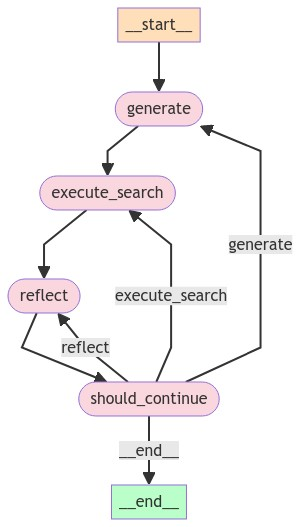

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [20]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "How can we mitigate climate change?",
    "max_revisions": 3,
    "revision_number": 0,
}, thread):
    print(s)

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': {'current_report': 'Climate change is a pressing global issue, and mitigating its effects requires a multifaceted approach. One crucial strategy is reducing greenhouse gas emissions, primarily from burning fossil fuels. This involves transitioning to renewable energy sources like solar and wind power, improving energy efficiency in buildings and transportation, and promoting sustainable agriculture and forestry practices. Additionally, carbon capture and storage technologies can play a role in removing existing carbon dioxide from the atmosphere.  Furthermore, adaptation measures are essential to cope with the unavoidable impacts of climate change. This includes building resilient infrastructure, developing drought-resistant crops, and managing water resources effectively. International cooperation is vital for addressing this global challenge, requiring coordinated efforts among governments, businesses, and individuals to implement effective solutions.', 'search_queries':

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is reducing greenhouse gas emissions, primarily from burning fossil fuels. This involves transitioning to renewable energy sources like solar and wind power, improving energy efficiency in buildings and transportation, and promoting sustainable agriculture and forestry practices. Additionally, carbon capture and storage (CCS) technologies can play a role in removing existing carbon dioxide from the atmosphere. However, CCS is still under development and faces challenges such as high costs and potential environmental risks.  Furthermore, adaptation measures are essential to cope with the unavoidable impacts of climate change. This includes building resilient infrastructure, developing drought-resistant crops, and managing water resources effectively. International cooperation is vital for addressing this global challenge, requiring

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is reducing greenhouse gas emissions, primarily from burning fossil fuels. This involves transitioning to renewable energy sources like solar and wind power, improving energy efficiency in buildings and transportation, and promoting sustainable agriculture and forestry practices. [1, 4, 5, 6] Additionally, carbon capture and storage (CCS) technologies can play a role in removing existing carbon dioxide from the atmosphere. [7, 8, 9] However, CCS is still under development and faces challenges such as high costs and potential environmental risks. [7] Furthermore, adaptation measures are essential to cope with the unavoidable impacts of climate change. [2, 3] This includes building resilient infrastructure, developing drought-resistant crops, and managing water resources effectively. [3] International cooperation is vital for addres

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': {'current_report': 'Climate change is a pressing global issue that requires a multifaceted approach to mitigate its effects. One crucial strategy is reducing greenhouse gas emissions, primarily from burning fossil fuels. This involves transitioning to renewable energy sources like solar and wind power, improving energy efficiency in buildings and transportation, and promoting sustainable agriculture and forestry practices. [1, 4, 5, 6] Additionally, carbon capture and storage (CCS) technologies can play a role in removing existing carbon dioxide from the atmosphere. [7, 8, 9] However, CCS is still under development and faces challenges such as high costs and potential environmental risks. [7] Furthermore, adaptation measures are essential to cope with the unavoidable impacts of climate change. [2, 3] This includes building resilient infrastructure, developing drought-resistant crops, and managing water resources effectively. [3] International cooperation is vital for addres

In [22]:
final_report = s['reflect']['current_report']
pprint.pprint(final_report)

('Climate change is a pressing global issue that requires a multifaceted '
 'approach to mitigate its effects. One crucial strategy is reducing '
 'greenhouse gas emissions, primarily from burning fossil fuels. This involves '
 'transitioning to renewable energy sources like solar and wind power, '
 'improving energy efficiency in buildings and transportation, and promoting '
 'sustainable agriculture and forestry practices. [1, 4, 5, 6] Additionally, '
 'carbon capture and storage (CCS) technologies can play a role in removing '
 'existing carbon dioxide from the atmosphere. [7, 8, 9] However, CCS is still '
 'under development and faces challenges such as high costs and potential '
 'environmental risks. [7] Furthermore, adaptation measures are essential to '
 'cope with the unavoidable impacts of climate change. [2, 3] This includes '
 'building resilient infrastructure, developing drought-resistant crops, and '
 'managing water resources effectively. [3] International cooperation i